# make peak catalogs from small patches

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
from datasets import load_dataset

data = load_dataset("/home2/shubh/ViT_weak_lensing/data/20230419_224x224/", cache_dir="/data2/shared/shubh/cache/")

/home2/shubh/.conda/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset 20230419_224x224 (/data2/shared/shubh/cache/20230419_224x224/noiseless/1.1.0/4722ad569846f10c2044e51ec08944e946e5ae355048ce3c8c9491f04ea4796b)
100%|██████████| 3/3 [02:59<00:00, 59.84s/it] 


In [3]:
np.array(data['test'][0]['map'])[:, :, 0].shape

(224, 224)

In [4]:
# add a Gaussian smoothing filter to the map

fwhm = 3
s = fwhm / (2 * np.sqrt(2 * np.log(2)))

orig_map = np.array(data['test'][0]['map'])[:, :, 0]
smooth_map = gaussian_filter(orig_map, sigma=s)

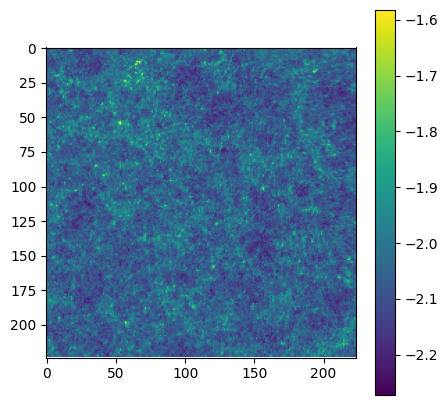

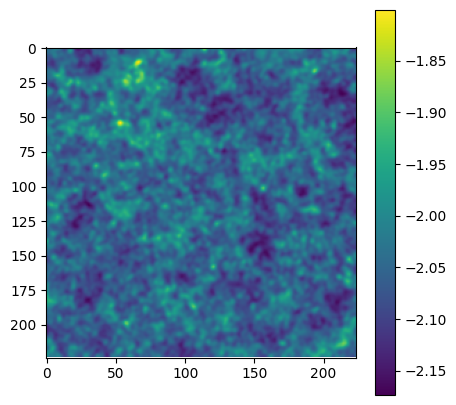

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(np.log10(orig_map))
plt.colorbar()
plt.show()
plt.close()

plt.figure(figsize=(5, 5))
plt.imshow(np.log10(smooth_map))
plt.colorbar()
plt.show()
plt.close()

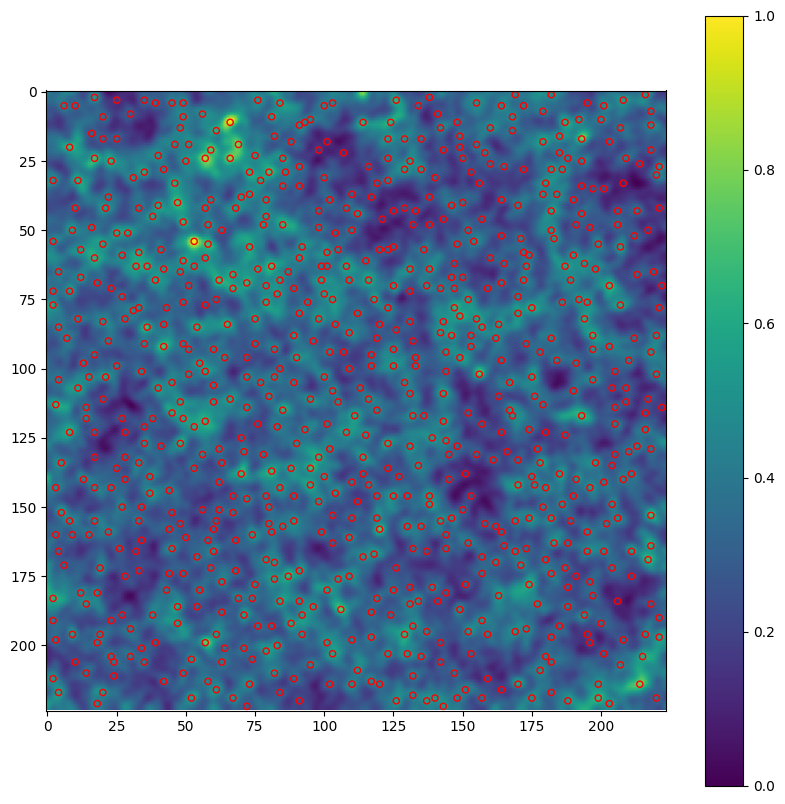

In [6]:
# find the peaks in the smoothed map

def get_peaks(img):
    key = 0
    ny, nx = img.shape
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            val = img[i, j]
            # check if this pixel is higher than all 8 neighbours
            if np.all(val >= img[i-1:i+2, j-1:j+2]):
                key += 1
                yield key, i, j, val

plt.figure(figsize=(10, 10))
plt.imshow(np.log10(smooth_map))
for key, i, j, val in get_peaks(smooth_map):
    plt.scatter(j, i, color='r', marker='o', facecolors='none', lw=1, s=20)
plt.colorbar()
plt.show()
plt.close()

(789,)
789 50176 0.01572464923469388


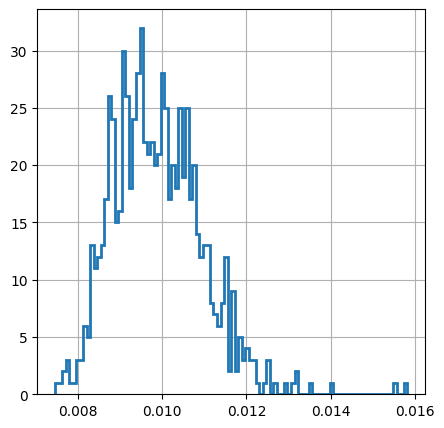

In [7]:
# plot histogram of peak values

peaks = np.array(list(get_peaks(smooth_map)), \
                 dtype=[('key', int), ('y', int), ('x', int), ('val', float)])
print(peaks.shape)
print(peaks.shape[0], len(smooth_map.flatten()), peaks.shape[0] / len(smooth_map.flatten()))

plt.figure(figsize=(5, 5))
plt.hist(peaks["val"], bins=100, histtype='step', lw=2)
plt.grid()
plt.show()
plt.close()


# making graphs

789


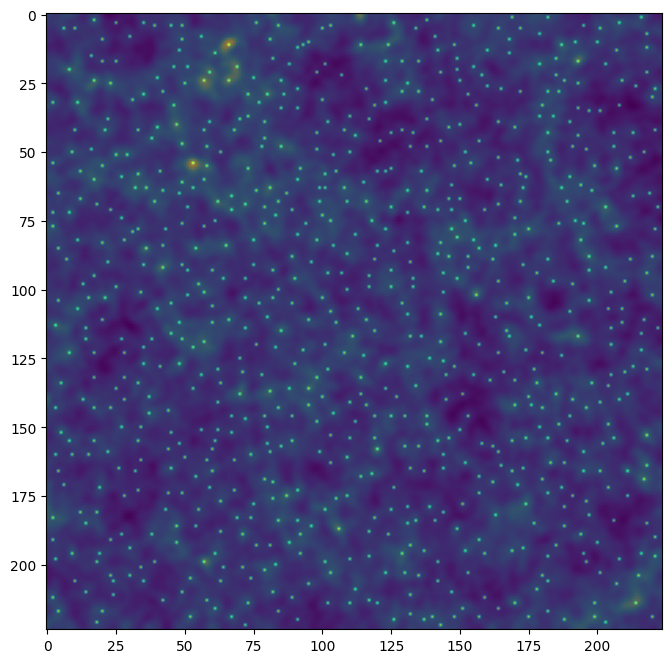

In [8]:
loc_peaks = np.zeros_like(smooth_map, dtype=int)
loc_peaks[peaks["y"], peaks["x"]] = peaks["key"]
print(np.sum(loc_peaks > 0))

plt.figure(figsize=(8, 8))
plt.imshow(np.log10(smooth_map))
plt.imshow(loc_peaks > 0, alpha=0.5)
plt.show()
plt.close()

In [9]:
# find peaks within a radius of 5 pixels of the peaks

def get_edges(peaks, radius):
    r = np.ceil(radius).astype(int)
    loc_peaks = np.zeros_like(smooth_map, dtype=int)
    loc_peaks[peaks["y"], peaks["x"]] = peaks["key"]
    loc_peaks = np.pad(loc_peaks, r, mode='constant')

    ny, nx = loc_peaks.shape
    for key, y, x, val in peaks:
        y, x = y + r, x + r # add the padding
        patch = loc_peaks[y-r:y+r+1, x-r:x+r+1] # extract the patch
        patch_peaks = np.nonzero(patch) # find the peaks in the patch
        for ay, ax in zip(patch_peaks[0], patch_peaks[1]):
            akey = patch[ay, ax]
            ay, ax = ay - r, ax - r # remove the padding
            sep = (ay**2 + ax**2)
            ang = np.arctan2(ay, ax)
            if 0 < sep <= radius**2: # check radius
                yield (key, akey), (y-r, x-r), (ay+y-r, ax+x-r), np.sqrt(sep), ang


radius = 8
for i in get_edges(peaks, radius):
    print(i)
    break

((1, 22), (1, 169), (5, 164), 6.4031242374328485, 2.4668517113662403)


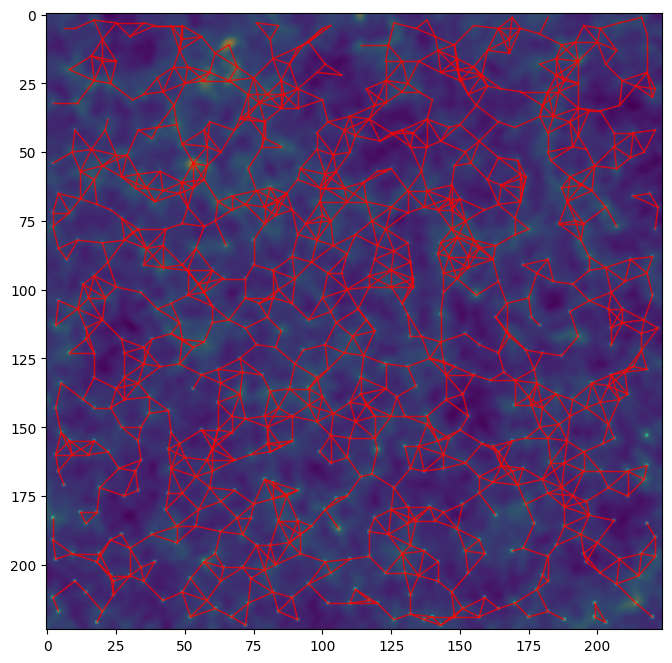

In [24]:
radius = 10
edges = np.array(list(get_edges(peaks, radius)), \
                    dtype=[('keys', tuple), ('p1', tuple), ('p2', tuple), ('sep', float), ('ang', float)])

plt.figure(figsize=(8, 8))
plt.imshow(np.log10(smooth_map))
for keys, (y, x), (ay, ax), sep, ang in edges:
    plt.plot([x, ax], [y, ay], color='r', lw=1, alpha=0.5)
plt.imshow(loc_peaks, alpha=0.5)
plt.show()
plt.close()

3272


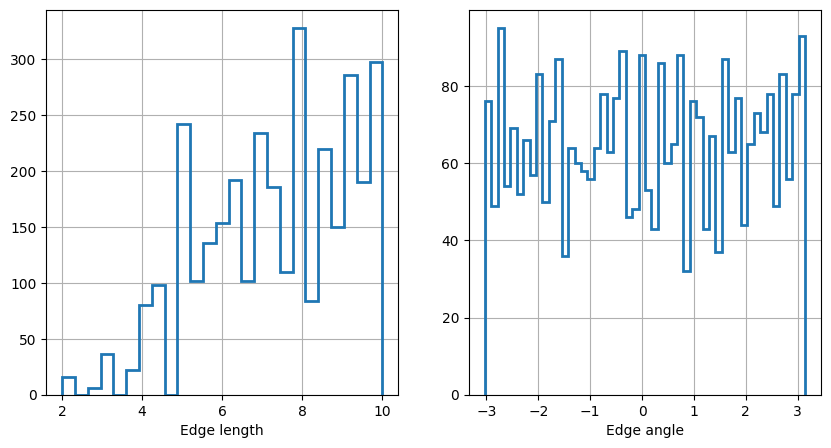

In [11]:
print(len(edges))

# plot histogram of edge lengths and angles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(edges["sep"], bins=25, histtype='step', lw=2)
ax1.set_xlabel("Edge length")
ax1.grid()
ax2.hist(edges["ang"], bins=50, histtype='step', lw=2)
ax2.set_xlabel("Edge angle")
ax2.grid()
plt.show()
plt.close()

In [12]:
peaks['key'], edges['keys']

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

In [ ]:
# check if the edges are symmetric
# that is for every (k1, k2) in edges["keys"], (k2, k1) should also be present

list_keys = list(edges["keys"]) # numpy "contains" method is weird 
for k1, k2 in list_keys:
    assert (k2, k1) in list_keys
    p1 = edges[[list_keys[ind] == (k1, k2) for ind in range(len(edges))]]
    p2 = edges[[list_keys[ind] == (k2, k1) for ind in range(len(edges))]]
    assert np.allclose(p1["sep"], p2["sep"])
    assert np.allclose(np.abs(p1["ang"]-p2["ang"]), np.pi)
